<a href="https://colab.research.google.com/github/Meghashyamt/Movie-Review-Sentiment-Analysis/blob/master/Movie_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:**

Sentiment Analysis is the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.
In this kernel, we will be creating a model which predicts sentiment of IMDB reviews.

**Data Description:**

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets.

# Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from IPython.display import HTML
from pathlib import Path

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

!pip install -q kaggle
!pip install -q kaggle-cli

import os
os.environ['KAGGLEUSERNAME'] = "shyamms18"
os.environ['KAGGLEKEY'] = "30f7d644fcdf6b9a9905a4a4c1a2dcf1"
!kaggle datasets download iarunava/imdb-movie-reviews-dataset

!unzip imdb-movie-reviews-dataset.zip

# Importing the Dataset

In [0]:
file_path = "aclImdb/"
pos_filenames = [file_path + "/train/pos/" + x for x in os.listdir(file_path + "train/pos/") if x.endswith(".txt")]
neg_filenames = [file_path + "/train/neg/" + x for x in os.listdir(file_path + "train/neg/") if x.endswith(".txt")]

positiveReviews, negativeReviews = [], []
for f in pos_filenames:
    positiveReviews.append(Path(f).read_text(encoding='utf8'))

for f in neg_filenames:
    negativeReviews.append(Path(f).read_text(encoding='utf8'))

## **Labelled Data with Positive as 1 and Negative as 0**

In [93]:
#Labelled data 1 'positive'  0 'negative'
dataset = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":pos_filenames}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":neg_filenames})
], ignore_index=True).sample(frac=1, random_state=1)

dataset.head()

,review,label,file
21492,"Now, I've seen a lot of bad movies. I like bad...",0,aclImdb//train/neg/10944_1.txt
9488,Any one who has seen Mel Gibson's The Passion ...,1,aclImdb//train/pos/2408_8.txt
16933,I found this film to be quite an oddity. From ...,0,aclImdb//train/neg/541_4.txt
12604,I was previously unaware that in the early 199...,0,aclImdb//train/neg/3950_1.txt
8222,"i, too, loved this series when i was a kid. In...",1,aclImdb//train/pos/2203_8.txt


## **Visualisation of Labelled data**

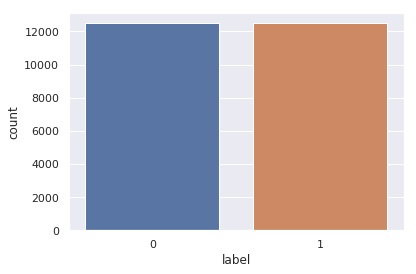

In [94]:
import seaborn as sns
sns.set(style="darkgrid")
#movie = sns.load_dataset("dataset")
ax = sns.countplot(x="label", data=dataset)

**Positive Review**: This was a great movie! Even though there was only about 15 people including myself there it was great! My friend and I laughed a lot. My mom even enjoyed it. There was two middle aged women there and a mid 20 year old there and they seemed to enjoy it. I love the part where Corky and Ned are like both liking Nancy and stuff its cute lol. And when she gets her roadster and Ned is there. Yeah This was a great movie even thought people underestimated it lol. Go See it i bet you'll enjoy it!! I really enjoyed it and so did my friend. 

People were so tough on this movie and they hadn't even seen it. I bet next time they will give the movie and actresses a chance. They all did a great job in my opinion. But if you have young kids its still appropriate. I will probably take my 7 year old niece to watch it too.

**Negative Review:** A bloody maniac with cannibalistic tendencies rapes a woman. He's been shot by two policemen and then he is risen from the grave because of some sort of satanic ceremonial rite preformed by an evil heresy. The hunting of women continues by this zombie-demon. The sacrificed baby returns from the grave and wants the maniac dead again, but only with the help of the police this will come true...

A bloody 65-minute mess...Horny zombies, doll-babies, S&M, corrupted and twisted policemen, repented heretics who seek refuge in front of Jesus Christ and three text-screens at the end of the film explaining us what finally happened to the policeman who survived (yes, we ought to know!)... Two decent disemboweling shots can't save the situation. I've seen worst horror-flicks, but this one was pretty bad too. Recommended only for the die-very-hard fans of the genre.

In [0]:
from bs4 import BeautifulSoup
dataset.review = dataset.review.apply(lambda r: BeautifulSoup(r, 'html.parser').get_text())

## **To replace other unwanted symbols and values in the reviews**

In [96]:
dataset.review.replace(to_replace ='[^a-z A-Z]', value = '', regex = True, inplace = True)
HTML(dataset.review.get(0)[:250])

In [97]:
dataset.review = dataset.review.str.lower()
HTML(dataset.review.get(0)[:250])

## **Remove the stop-words, duplicate words and Lemmatize the words**
Stop-Word: A stop word is a commonly used word such as “the”, “a”, “an”, “in”, etc. We would not want these words to be included as feature in our dataset.

Lemmatization: Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
Example:

rocks : rock
corpora : corpus
better : good
learning : learn

In [98]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))
dataset.review = dataset.review.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in set(x.split()) if word not in english_stopwords]))
HTML(dataset.review.get(0)[:250])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Finding the length of the Random review taken**

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCABS = 10000

tokenizer = Tokenizer(num_words = MAX_VOCABS)
tokenizer.fit_on_texts(pd.concat([dataset.review]))
x = tokenizer.texts_to_sequences(dataset.review)

print("Length of 1st example: ", len(x[0]))
print("Length of 5th example: ",  len(x[5]))
print("Length of 16th example: ",  len(x[16]))

Length of 1st example:  99
Length of 5th example:  34
Length of 16th example:  63


## **Maximum number of words**

In [100]:
print("Maximum number of words in the reviews: ", max([len(i) for i in x]))

Maximum number of words in the reviews:  509


In [101]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = max([len(i) for i in x])
vocab_size = MAX_VOCABS + 1
x = pad_sequences(x, padding='post', maxlen=MAX_LEN, value=vocab_size)

print("Length of 1st example: ", len(x[0]))
print("Length of 5th example: ",  len(x[5]))
print("Length of 16th example: ",  len(x[16]))

Length of 1st example:  509
Length of 5th example:  509
Length of 16th example:  509


## **Train and Testing the dataset**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, dataset.label, test_size = 0.2, random_state = 1)

## **Building and Training the model**

In [157]:
#Build and Train the model
embedd_dim = 16

model = keras.Sequential([
    keras.layers.Embedding(vocab_size + 1, embedd_dim),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(212, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(212, activation='relu'),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(212, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs=300,  batch_size=200, verbose = 2, validation_data = (x_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/300
20000/20000 - 2s - loss: 0.6924 - acc: 0.5171 - val_loss: 0.6816 - val_acc: 0.7712
Epoch 2/300
20000/20000 - 1s - loss: 0.4644 - acc: 0.7822 - val_loss: 0.3110 - val_acc: 0.8680
Epoch 3/300
20000/20000 - 1s - loss: 0.2530 - acc: 0.9015 - val_loss: 0.2791 - val_acc: 0.8878
Epoch 4/300
20000/20000 - 1s - loss: 0.1943 - acc: 0.9273 - val_loss: 0.2814 - val_acc: 0.8898
Epoch 5/300
20000/20000 - 1s - loss: 0.1603 - acc: 0.9434 - val_loss: 0.3328 - val_acc: 0.8758
Epoch 6/300
20000/20000 - 1s - loss: 0.1390 - acc: 0.9517 - val_loss: 0.3534 - val_acc: 0.8652
Epoch 7/300
20000/20000 - 1s - loss: 0.1266 - acc: 0.9573 - val_loss: 0.3363 - val_acc: 0.8842
Epoch 8/300
20000/20000 - 1s - loss: 0.0955 - acc: 0.9703 - val_loss: 0.3533 - val_acc: 0.8838
Epoch 9/300
20000/20000 - 1s - loss: 0.0876 - acc: 0.9724 - val_loss: 0.4257 - val_acc: 0.8730
Epoch 10/300
20000/20000 - 1s - loss: 0.0719 - acc: 0.9794 - val_loss: 0.4296 - val_acc: 0.8774


## Visualization 

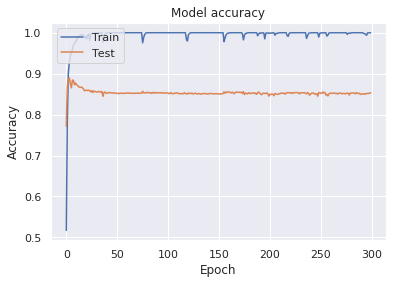

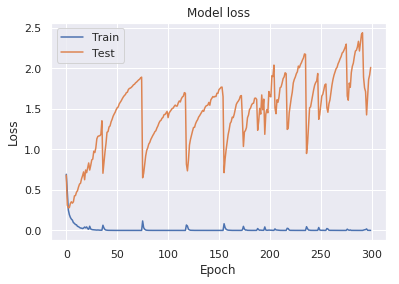

In [158]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## **Confusion Matrix**

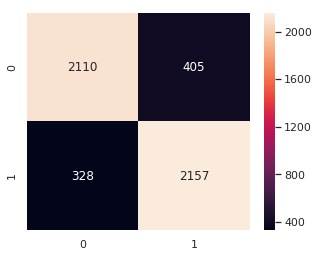

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = model.predict_classes(x_test)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (5, 4))
sn.heatmap(df_cm, annot=True, fmt='g')

## **Classification Report**

In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2515
           1       0.84      0.87      0.85      2485

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



## **Accuracy**

In [161]:
Accuracy=model.evaluate(x_test,y_test)

5000/5000 [==============================] - 0s 65us/sample - loss: 2.0103 - acc: 0.8534


In [162]:
Accuracy

[2.010269424247742, 0.8534]